In [2]:
import tensorflow as tf
tf.enable_eager_execution()
import glob
from PIL import Image

In [3]:
from tensorflow import keras
import numpy as np
import random

In [4]:
train_images = glob.glob('./data/DataSets/att_faces/Training/*/*')
test_images = glob.glob('./data/DataSets/att_faces/Testing/*/*')

In [5]:
import re
import itertools

def get_label(path):
    """ Get the label (s**) from the file path """
    try:
        return re.search(r'/s[\d]+/', path).group()[1:-1]
    except:
        print(path)
        raise
    
# dictionary with label -> A list of file paths under that label
dict_train = itertools.groupby(train_images, lambda x: get_label(x))
dict_train = {k: list(v) for k, v in dict_train}

dict_test = itertools.groupby(test_images, lambda x: get_label(x))
dict_test = {k: list(v) for k, v in dict_test}

labels = list(dict_train.keys())
len(labels)

40

In [6]:
def generate_pair_samples(d, pos_ratio=1, seed=1024):
    np.random.seed(seed)
    
    samples = []
    for label in labels:
        # positive samples
        pos_samples = list(itertools.combinations(d[label], 2))
        samples.extend([i + ('1', ) for i in pos_samples])
        
        # negative samples
        n_neg = int(len(pos_samples) / pos_ratio)
        for _ in range(n_neg):
            a = random.choice(d[label])
            l = random.choice([i for i in labels if i != label])
            b = random.choice(d[l])
            samples.append((a, b, '0'))
            
    random.shuffle(samples)
    return samples

In [7]:
from PIL import Image

def read_image(file_path):
    img = np.asarray(Image.open(file_path))
    return img[..., np.newaxis].astype('float32')

def preprocess(x):
    """ x is a pair of image path """
    return read_image(x[0]), read_image(x[1]), int(x[2])

In [8]:
def train_generator():
    for p in generate_pair_samples(dict_train):
        yield preprocess(p)

In [9]:
train_dataset = tf.data.Dataset.from_generator(train_generator, (tf.float32, tf.float32, tf.int32))
train_dataset = train_dataset.batch(2)

In [10]:
sample = next(iter(train_dataset))

## building the network

In [11]:
class Convnet(keras.Model):
    
    def __init__(self, filter_size=[15, 30, 30], **kwargs):
        super().__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(filters=filter_size[0], kernel_size=5)
        self.pool1 = keras.layers.MaxPooling2D()
        self.conv2 = keras.layers.Conv2D(filters=filter_size[1], kernel_size=5)
        self.pool2 = keras.layers.MaxPooling2D()
        self.conv3 = keras.layers.Conv2D(filters=filter_size[2], kernel_size=5)
        self.pool3 = keras.layers.MaxPool2D()
        self.flatten = keras.layers.Flatten()
        self.fc1 = keras.layers.Dense(30)
        
    def call(self, img):
        for layer in [self.conv1, self.pool1, self.conv2, self.pool2, self.conv3, self.pool3, 
                      self.flatten, self.fc1]:
            img = layer(img)
        return img
    
    def calculate_dist(self, a, b):
        """ Calculate the l2 distance between the vector representation of image a and b 
            output shape [batch_size, ]
        """
        encoded_a, encoded_b = self.call(a), self.call(b)
        return tf.reduce_mean(tf.square(encoded_a - encoded_b), axis=1)
    
    def calcualte_loss(self, a, b, label):
        dist = self.calculate_dist(a, b)
        return tf.reduce_mean(tf.cast(1-label, dist.dtype) * dist)

In [67]:
train_dataset = tf.data.Dataset.from_generator(train_generator, (tf.float32, tf.float32, tf.int32))
# train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.batch(32)

In [66]:
convnet = Convnet()
opt = tf.train.AdamOptimizer()

In [14]:
# the training loop
N_EPOCH = 1
N_STEP = 5

for epoch in range(N_EPOCH):
    for step, (img_a, img_b, label) in enumerate(train_dataset):
        loss = convnet.calcualte_loss(img_a, img_b, label)
        
        with tf.GradientTape() as tape:
            loss = convnet.calcualte_loss(img_a, img_b, label)

        gradients = tape.gradient(loss, convnet.trainable_variables)
        opt.apply_gradients(zip(gradients, convnet.trainable_variables))
        
        if step % 10 == 0:
            print(step, loss)

0 tf.Tensor(214.14368, shape=(), dtype=float32)
10 tf.Tensor(10.417885, shape=(), dtype=float32)
20 tf.Tensor(10.4138155, shape=(), dtype=float32)
30 tf.Tensor(4.8037114, shape=(), dtype=float32)
40 tf.Tensor(3.4356508, shape=(), dtype=float32)
50 tf.Tensor(2.1982093, shape=(), dtype=float32)
60 tf.Tensor(1.9420372, shape=(), dtype=float32)
70 tf.Tensor(1.5033114, shape=(), dtype=float32)
80 tf.Tensor(1.7282585, shape=(), dtype=float32)


In [ ]:
def calcualte_dist(path_1, path_2):
    img_1, img_2 = read_image(path_1), read_image(path_2)
    dist = convnet.calculate_dist(np.expand_dims(img_1, 0), np.expand_dims(img_2, 0))
    return dist.numpy()[0]
    
calcualte_dist(train_images[0], train_images[15])

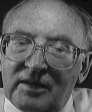

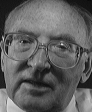

In [65]:
Image.open(train_images[0])
Image.open(train_images[3])